In [51]:
import pandas as pd
import numpy as np
import os

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import functools

import h5py

### Environmental vars

In [52]:
P_THRESHOLD=0.5

In [53]:
DATADIR = os.getenv('DATADIR')

### get some data about taxons/content

In [54]:
labelled_level2 = pd.read_csv(
    os.path.join(DATADIR, 'labelled_level2.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [55]:
# Create World taxon in case any items not identified 
# through doc type in clean_content are still present
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

In [56]:
# creating categorical variable for level2taxons from values
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

# Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
labelled_level2['level2taxon_code'] = labelled_level2.level2taxon.astype('category').cat.codes + 1

# create dictionary of taxon category code to string label for use in model evaluation
labels_index = dict(zip((labelled_level2['level2taxon_code']),
                        labelled_level2['level2taxon']))

In [ ]:
labelled_level2.groupby('level2taxon').size().sort_values(ascending=False).plot(kind = 'barh', figsize=(10,30))

### Load in data

In [62]:
true_train = pd.read_csv(os.path.join(DATADIR, 'true_train_1726_1203_.csv.gz'), dtype=float, compression='gzip')
pred_train = pd.read_csv(os.path.join(DATADIR, 'train_results_1726_1203_.csv.gz'), dtype=float, compression='gzip')

In [63]:
true_dev = pd.read_csv(os.path.join(DATADIR, 'true_dev_1726_1203_.csv.gz'), dtype=float, compression='gzip')
prob_dev = pd.read_csv(os.path.join(DATADIR, 'dev_results_1726_1203_.csv.gz'), dtype=float, compression='gzip')

In [64]:
train = np.load(os.path.join(DATADIR, 'train_arrays.npz'))

In [65]:
dev = np.load(os.path.join(DATADIR, 'dev_arrays.npz'))

In [ ]:
train

In [66]:
labelled_level2.loc[labelled_level2['content_id'].isin(train['content_id'])]

,base_path,content_id,content_purpose_document_supertype,content_purpose_subgroup,content_purpose_supergroup,description,details,document_type,email_document_supertype,first_published_at,...,combined_text,taxon_id,taxon_base_path,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,level5taxon,level2taxon_code
1,/government/news/one-million-pounds-for-a-star...,5e66eea3-7631-11e4-a3cb-005056011aef,news,news,news_and_communications,"the ""million pound startup"" is a global contes...","{'body': '<div class=""govspeak""><p>Startup com...",world_news_story,announcements,2013-08-27 15:11:00.000,...,win £1 million to move your startup to london ...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,21
4,/government/news/cutting-eu-red-tape-must-be-a...,5fa614c3-7631-11e4-a3cb-005056011aef,news,news,news_and_communications,european leaders have agreed that the eu must ...,"{'body': '<div class=""govspeak""><p>European le...",world_news_story,announcements,2014-07-04 15:35:00.000,...,cutting eu red tape must be a priority europea...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,21
6,/government/news/michael-fallon-illustrates-pr...,5f63fc50-7631-11e4-a3cb-005056011aef,news,news,news_and_communications,minister explains benefits of ppc scheme at a ...,"{'body': '<div class=""govspeak""><p>Michael Fal...",world_news_story,announcements,2014-06-13 15:24:05.000,...,michael fallon illustrates prompt payment code...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,21
8,/government/news/baroness-nicholson-leads-busi...,a18b56dc-e293-438b-b596-3915e5cc6e72,news,news,news_and_communications,prime minister’s trade envoy leads high level ...,"{'body': '<div class=""govspeak""><p>The UK Prim...",world_news_story,announcements,2016-06-20 09:16:00.000,...,baroness nicholson leads business delegation t...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,21
9,/government/news/uk-companies-explore-bulgaria...,5f4e1e56-7631-11e4-a3cb-005056011aef,news,news,news_and_communications,leading uk infrastructure companies discuss op...,"{'body': '<div class=""govspeak""><p>UK business...",world_news_story,announcements,2014-04-11 09:12:17.000,...,uk companies explore bulgarian infrastructure ...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,21
10,/government/news/prime-ministers-trade-envoy-v...,d9cdd2cc-5885-4953-927b-4eacc6e8e424,news,news,news_and_communications,richard graham mp will lead a large uk busines...,"{'body': '<div class=""govspeak""><p>Richard Gra...",world_news_story,announcements,2017-03-17 03:23:01.000,...,prime minister's trade envoy visits the philip...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,21
11,/government/news/30-israeli-tech-companies-to-...,5f12a0a1-7631-11e4-a3cb-005056011aef,news,news,news_and_communications,london to play host to 30 of israel’s most exc...,"{'body': '<div class=""govspeak""><p>In March of...",world_news_story,announcements,2014-02-12 10:45:00.000,...,30 israeli tech companies to pursue business c...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,21
12,/government/news/retail-opportunities-in-polan...,5f544882-7631-11e4-a3cb-005056011aef,news,news,news_and_communications,opportunity for uk companies to meet business ...,"{'body': '<div class=""govspeak""><p>Poland has ...",world_news_story,announcements,2014-05-05 10:51:16.000,...,retail opportunities in poland for u

In [ ]:
train.files

In [ ]:
train['content_id']

In [ ]:
train['content_id'].shape

In [ ]:
true_train.shape[0]

### Evaluate model

#### Training metrics

In [11]:
y_pred = pred_train.copy()

In [12]:
y_pred[y_pred>=P_THRESHOLD] = 1
y_pred[y_pred<P_THRESHOLD] = 0

In [ ]:
print('micro: {}'.format(precision_recall_fscore_support(true_train, y_pred, average='micro', sample_weight=None)))
print('macro: {}'.format(precision_recall_fscore_support(true_train, y_pred, average='macro', sample_weight=None)))
print('weightedmacro: {}'.format(precision_recall_fscore_support(true_train, y_pred, average='weighted', sample_weight=None)))

In [14]:
eval_metrics = precision_recall_fscore_support(true_train, y_pred, average=None, sample_weight=None)
eval_metrics_df = pd.DataFrame(list(eval_metrics))

In [15]:
train_metrics = eval_metrics_df.transpose()
train_metrics.columns = ['precision', 'recall', 'f1', 'support']
train_metrics['level2code'] = train_metrics.index +1
train_metrics['level2label'] = train_metrics['level2code'].map(labels_index)

In [16]:
train_metrics.head()

,precision,recall,f1,support,level2code,level2label
0,1.000000,1.000000,1.000000,528.0,1,Administrative justice reform
1,0.987414,1.000000,0.993667,863.0,2,"Adoption, fostering and surrogacy"
2,0.980594,0.970621,0.975582,885.0,3,Afghanistan
3,0.976552,0.988827,0.982651,716.0,4,Armed Forces Covenant
4,1.000000,1.000000,1.000000,1095.0,5,Armed forces


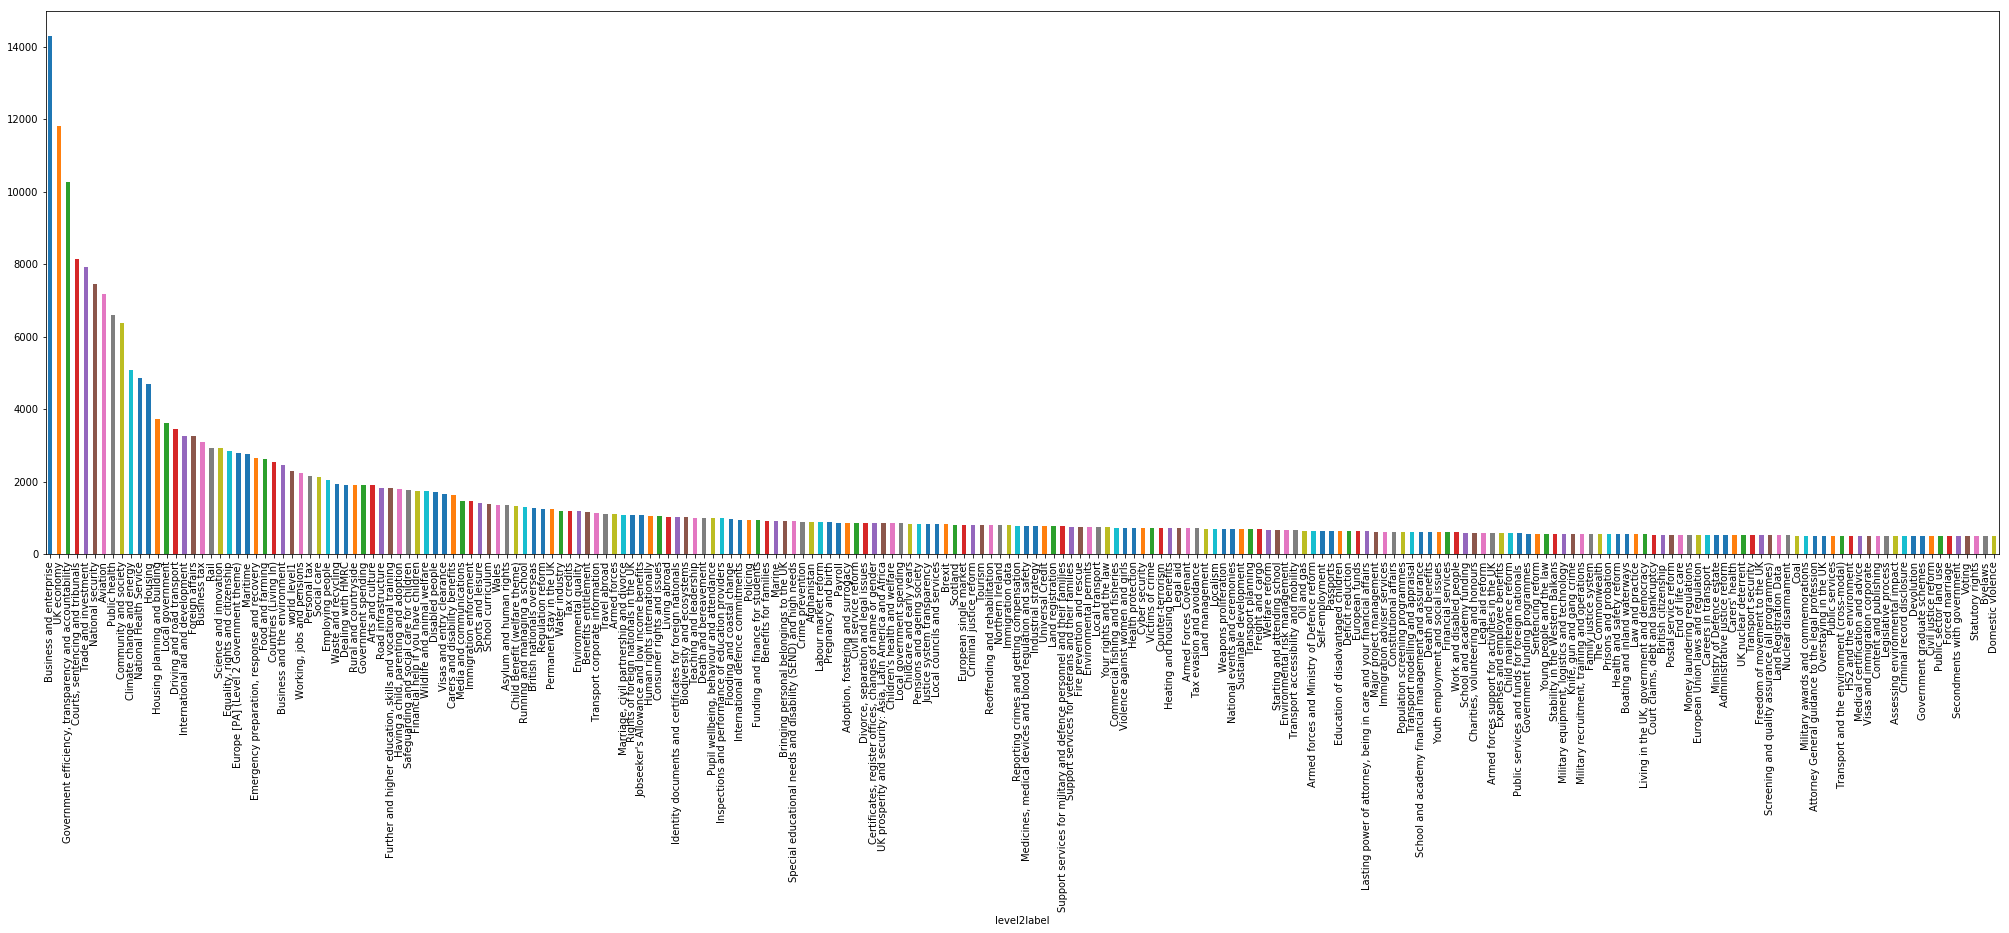

In [38]:
train_metrics.sort_values('support', ascending=False).plot(x='level2label', y='support', kind = 'bar', figsize=(35,10), legend=False)

#### Development set metrics

In [39]:
pred_dev = prob_dev.copy()

In [40]:
pred_dev[pred_dev>=P_THRESHOLD] = 1
pred_dev[pred_dev<P_THRESHOLD] = 0

In [41]:
print('micro: {}'.format(precision_recall_fscore_support(true_dev, pred_dev, average='micro', sample_weight=None)))
print('macro: {}'.format(precision_recall_fscore_support(true_dev, pred_dev, average='macro', sample_weight=None)))
print('weightedmacro: {}'.format(precision_recall_fscore_support(true_dev, pred_dev, average='weighted', sample_weight=None)))

micro: (0.85547355473554731, 0.80872093023255809, 0.83144052600119545, None)
macro: (0.73534006609310076, 0.7859479742417822, 0.75019336121687819, None)
weightedmacro: (0.85730461885311171, 0.80872093023255809, 0.82884073909017519, None)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [42]:
eval_metrics = precision_recall_fscore_support(true_dev, pred_dev, average=None, sample_weight=None)
eval_metrics_df = pd.DataFrame(list(eval_metrics))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [43]:
dev_metrics = eval_metrics_df.transpose()
dev_metrics.columns = ['precision', 'recall', 'f1', 'support']
dev_metrics['taxon2code'] = dev_metrics.index +1
dev_metrics['taxon2label'] = dev_metrics['taxon2code'].map(labels_index)

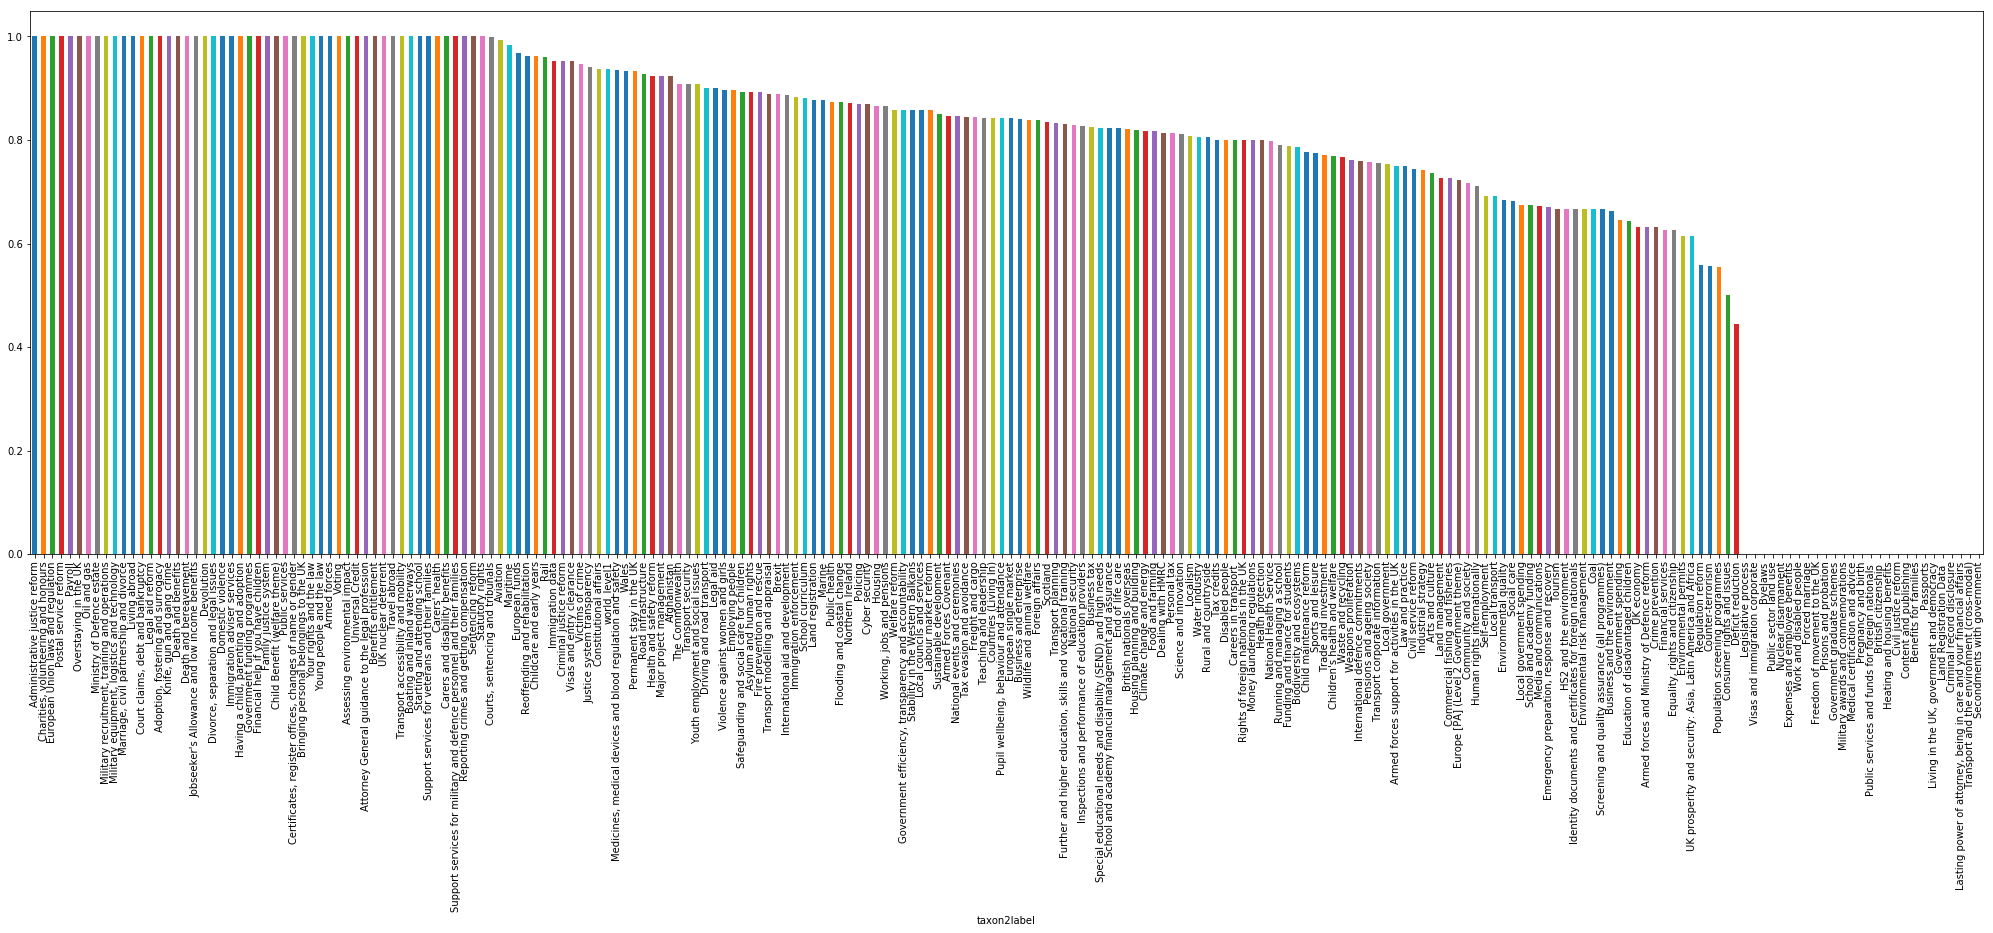

In [45]:
dev_metrics.sort_values('f1', ascending=False).plot(x='taxon2label', y='f1', kind = 'bar', figsize=(35,10), legend=False)

In [ ]:
dev_metrics.sort_values('taxon2label', ascending=True).plot(x='taxon2label', y='f1', kind = 'bar', figsize=(35,10), legend=False)

In [36]:
dev_metrics[dev_metrics['f1']==0].shape[0]

22

In [37]:
dev_metrics[dev_metrics['f1']==1].shape[0]

51

In [38]:
dev_metrics[dev_metrics['f1']==1]

,precision,recall,f1,support,taxon2code,taxon2label
4,1.0,1.0,1.0,59.0,5,Armed forces
8,1.0,1.0,1.0,1.0,9,Assessing environmental impact
12,1.0,1.0,1.0,4.0,13,Benefits entitlement
13,1.0,1.0,1.0,3.0,14,Benefits for families
17,1.0,1.0,1.0,1.0,18,Bringing personal belongings to the UK
23,1.0,1.0,1.0,1.0,24,Byelaws
24,1.0,1.0,1.0,4.0,25,Careers in transport
25,1.0,1.0,1.0,2.0,26,Carers and disability benefits
27,1.0,1.0,1.0,1.0,28,"Certificates, register offices, changes of nam..."
28,1.0,1.0,1.0,5.0,29,"Charities, volunteering and honours"


In [39]:
dev_metrics.to_csv(os.path.join(DATADIR, "dev_metrics.csv.gz"), compression='gzip',index=False)

In [71]:
high = dev_metrics[dev_metrics['f1']>0.9]

In [72]:
morethan80 = dev_metrics[dev_metrics['f1']>0.8]

In [73]:
dev_metrics[dev_metrics['f1']<0.6].shape[0]

31

## support and performance

The support is the number of occurrences of each class in y_true

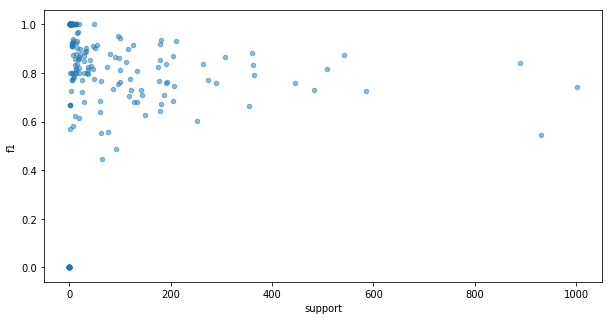

In [110]:
dev_metrics.plot.scatter(x='support', y='f1', marker='o', alpha=.5, figsize=(10, 5))


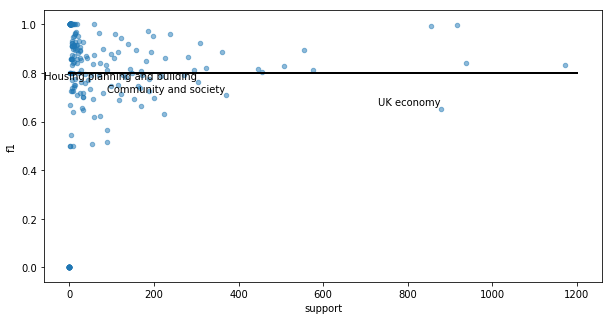

In [61]:
dev_metrics.plot.scatter(x='support', y='f1', marker='o', alpha=.5, figsize=(10, 5))
plt.plot([0, 1200],[0.8, 0.8],  'k-', lw=2)

for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
    if (x>300 and y<0.8):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
    if (y==1):
        label = ""
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
        
plt.show()

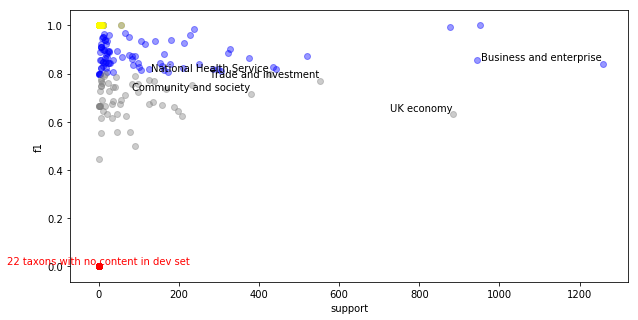

In [48]:
# normal values
plt.figure(figsize=(10, 5))
plt.text(0, 0, "22 taxons with no content in dev set", color='red', horizontalalignment='center', 
         verticalalignment='bottom')
plt.xlabel('support')
plt.ylabel('f1')
plt.scatter(dev_metrics['support'][dev_metrics['f1']>=0.8], 
            dev_metrics['f1'][dev_metrics['f1']>=0.8], 
            c = 'b', 
            alpha=.4)
# less than 0.8
plt.scatter(dev_metrics['support'][dev_metrics['f1']<0.8], 
            dev_metrics['f1'][dev_metrics['f1']<0.8], 
            c = 'grey', 
            alpha=.4)

plt.scatter(dev_metrics['support'][dev_metrics['f1']==0], 
            dev_metrics['f1'][dev_metrics['f1']==0], 
            c = 'red', 
            alpha=.4)
plt.scatter(dev_metrics['support'][dev_metrics['f1']==1], 
            dev_metrics['f1'][dev_metrics['f1']==1], 
            c = 'yellow', 
            alpha=.4)


for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
    if ((x>300 and y<0.8) or (x>1000)):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
    if (y==1):
        label = ""
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')


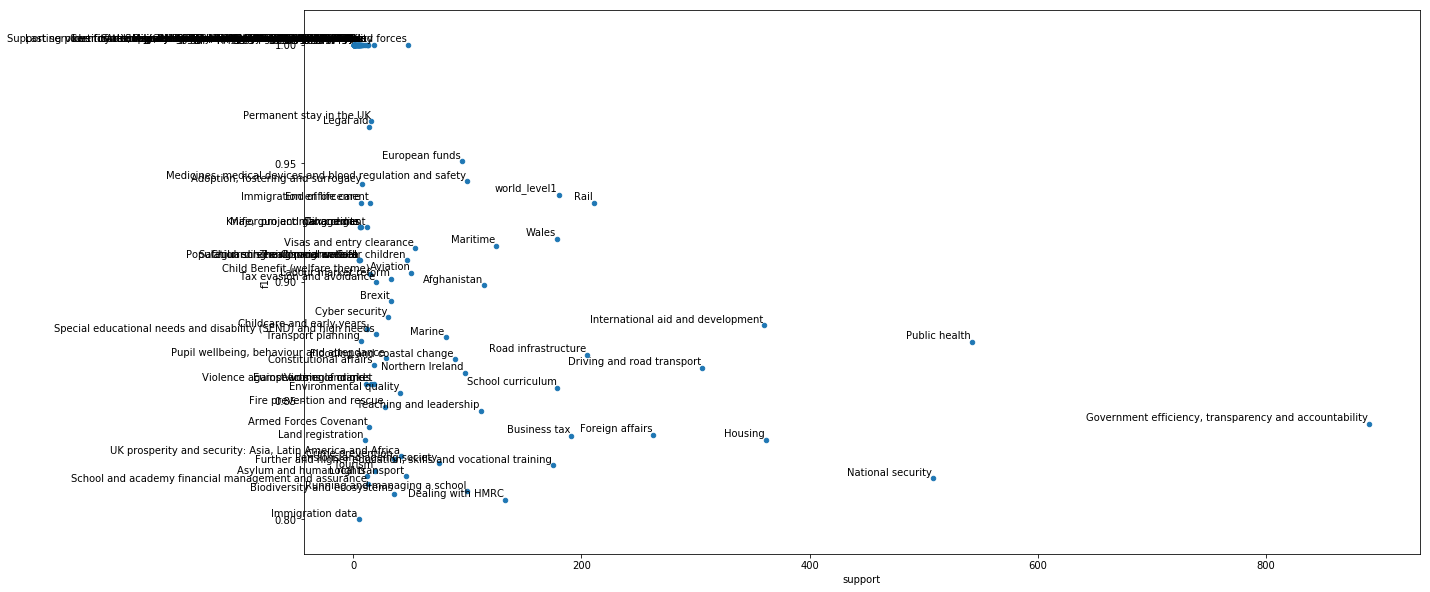

In [75]:
morethan80.plot.scatter(x='support', y='f1', figsize=(20, 10))

for label, x, y in zip(morethan80['taxon2label'], morethan80['support'], morethan80['f1']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-1, 1),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

### look at content predicted in taxons with f1=1

In [76]:
prob_dev.head()

,1,2,3,4,5,6,7,8,9,10,...,209,210,211,212,213,214,215,216,217,218
0,1.165881e-14,1.807397e-13,3.451293e-14,6.287820e-17,1.668254e-19,2.073975e-12,7.396179e-18,5.113691e-08,2.129879e-15,9.067941e-17,...,1.271009e-15,3.133356e-12,1.538252e-08,4.587988e-11,2.258334e-14,3.153224e-16,8.787685e-15,3.988735e-19,2.770739e-10,2.139895e-07
1,1.514083e-07,3.331143e-08,1.139475e-11,2.844467e-08,2.094252e-08,3.088199e-06,6.567718e-07,1.071657e-02,2.880979e-07,8.789715e-07,...,2.063507e-07,4.653625e-09,9.266956e-07,2.628897e-04,3.868810e-08,2.864378e-11,7.613178e-11,9.788504e-10,7.304470e-09,1.223808e-06
2,7.031448e-17,8.579963e-22,3.245885e-36,5.242608e-36,8.642692e-25,3.796147e-33,4.248200e-37,3.241169e-30,4.862877e-16,1.922038e-21,...,6.359810e-30,2.174244e-35,5.060508e-24,1.272333e-23,2.863876e-18,8.664010e-19,7.967176e-20,4.724785e-15,1.464422e-25,5.487067e-20
3,3.387666e-10,4.323407e-09,4.398544e-15,7.354882e-13,1.606409e-06,9.283779e-13,4.268500e-17,1.847909e-04,6.933860e-11,4.047880e-11,...,1.732335e-05,1.096070e-17,1.601181e-11,1.159819e-05,2.574492e-07,6.070632e-08,2.169033e-09,3.267043e-08,3.601657e-13,2.845138e-13
4,4.072112e-03,4.451071e-08,1.950250e-04,1.586458e-06,6.852108e-07,3.679448e-05,4.754758e-06,1.948295e-04,9.512553e-07,8.772676e-06,...,4.271441e-06,3.044638e-04,6.170463e-04,3.163516e-04,9.538026e-07,2.310041e-06,4.361569e-06,1.350610e-04,1.061749e-06,1.087103e-05


In [77]:
dev_metrics[dev_metrics['f1']==1].head()

,precision,recall,f1,support,taxon2code,taxon2label
4,1.0,1.0,1.0,48.0,5,Armed forces
8,1.0,1.0,1.0,1.0,9,Assessing environmental impact
10,1.0,1.0,1.0,3.0,11,Attorney General guidance to the legal profession
13,1.0,1.0,1.0,1.0,14,Benefits for families
17,1.0,1.0,1.0,1.0,18,Bringing personal belongings to the UK


In [78]:
perfect_performance = dev_metrics[dev_metrics['f1']==1].taxon2code.unique()
perfect_performance = perfect_performance.astype(str)

In [79]:
keep_perfect_performing_taxons = prob_dev[perfect_performance].copy()

In [80]:
keep_perfect_performing_taxons.shape

(10377, 68)

In [81]:
if dev['content_id'].shape[0] == keep_perfect_performing_taxons.shape[0]:
    keep_perfect_performing_taxons['content_id'] = dev['content_id']
else:
    print("warning: true_train and content_id may not originate from same data")

In [82]:
keep_perfect_performing_taxons.head()

,5,9,11,14,18,25,27,28,29,45,...,191,194,196,197,199,201,214,215,217,content_id
0,1.668254e-19,2.129879e-15,8.418954e-15,3.293599e-14,3.239779e-14,6.680569e-17,3.710611e-13,6.194689e-15,5.778313e-16,2.690364e-17,...,3.150220e-15,2.288571e-20,1.319374e-22,2.223906e-18,5.620565e-16,9.086407e-11,3.153224e-16,8.787685e-15,2.770739e-10,5fa7c2b0-7631-11e4-a3cb-005056011aef
1,2.094252e-08,2.880979e-07,3.026150e-07,2.123490e-08,1.373404e-07,1.384123e-05,3.446244e-09,2.184257e-07,5.009768e-06,1.398183e-06,...,4.383364e-07,8.015632e-06,1.855992e-08,8.488502e-10,5.615145e-08,4.604862e-08,2.864378e-11,7.613178e-11,7.304470e-09,f06014da-89dd-4543-b122-7ad51cfc3c50
2,8.642692e-25,4.862877e-16,1.002297e-27,6.527416e-22,1.915772e-28,1.788164e-28,7.160400e-32,4.935302e-20,3.779466e-14,7.663100e-27,...,7.023895e-30,8.602508e-30,4.827196e-35,3.005965e-20,1.565638e-34,8.098269e-18,8.664010e-19,7.967176e-20,1.464422e-25,b6b45948-ff2f-416d-a90a-80870e02ca6a
3,1.606409e-06,6.933860e-11,5.390022e-11,2.403999e-09,1.742370e-12,2.899255e-14,2.799545e-15,4.731656e-08,1.767865e-03,2.004690e-09,...,3.251877e-10,1.392769e-13,1.786081e-17,4.473626e-08,1.327482e-13,2.737062e-08,6.070632e-08,2.169033e-09,3.601657e-13,a302e3f9-1169-48c6-9cab-94c9f326eca4
4,6.852108e-07,9.512553e-07,1.906079e-05,1.242004e-07,6.762887e-05,3.122817e-05,3.254249e-06,6.349587e-06,7.511213e-07,1.342090e-06,...,2.210734e-05,7.027055e-07,1.378359e-04,1.112837e-06,1.957510e-04,1.406502e-05,2.310041e-06,4.361569e-06,1.061749e-06,3161b773-2bd1-4cbd-9d06-a55562164c32


In [83]:
# armed forces

keep_perfect_performing_taxons[keep_perfect_performing_taxons['5'] > 0.5].shape

(48, 69)

In [84]:
perfect_by_id = pd.melt(keep_perfect_performing_taxons, 
                        id_vars=['content_id'], var_name='taxon2', value_name='prob')

In [85]:
perfect_by_id.shape

(705636, 3)

In [86]:
positive_perfect = perfect_by_id[perfect_by_id['prob']>0.5].copy()

In [87]:
positive_perfect.shape

(309, 3)

In [88]:
positive_perfect_meta = pd.merge(
    left=positive_perfect,
    right=labelled_level2,
    on='content_id',
    how='left',
    indicator=True, 
    validate='m:m'
)

In [89]:
positive_perfect_meta['taxon2label'] = pd.to_numeric(positive_perfect_meta['taxon2']).map(labels_index)

In [90]:
positive_perfect_meta

,content_id,taxon2,prob,base_path,content_purpose_document_supertype,content_purpose_subgroup,content_purpose_supergroup,description,details,document_type,...,taxon_base_path,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,level5taxon,level2taxon_code,_merge,taxon2label
0,5c9c8a62-7631-11e4-a3cb-005056011aef,5,1.000000,/government/fatalities/drummer-thomas-wright-k...,updates-and-alerts,NaN,NaN,it is with deep sadness that the ministry of d...,{'emphasised_organisations': ['d994e55c-48c9-4...,fatality_notice,...,/defence/working-armed-forces,Armed forces,Defence,Armed forces,NaN,NaN,NaN,5,both,Armed forces
1,5c9c09e4-7631-11e4-a3cb-005056011aef,5,1.000000,/government/fatalities/sergeant-stuart-millar-...,updates-and-alerts,NaN,NaN,it is with sadness that the ministry of defenc...,{'emphasised_organisations': ['d994e55c-48c9-4...,fatality_notice,...,/defence/working-armed-forces,Armed forces,Defence,Armed forces,NaN,NaN,NaN,5,both,Armed forces
2,5c9cf0ab-7631-11e4-a3cb-005056011aef,5,1.000000,/government/fatalities/corporal-harvey-holmes-...,updates-and-alerts,NaN,NaN,it is with sadness the ministry of defence mus...,{'emphasised_organisations': ['d994e55c-48c9-4...,fatality_notice,...,/defence/working-armed-forces,Armed forces,Defence,Armed forces,NaN,NaN,NaN,5,both,Armed forces
3,5c9ce826-7631-11e4-a3cb-005056011aef,5,1.000000,/government/fatalities/sapper-guy-mellors-kill...,updates-and-alerts,NaN,NaN,it is with deep regret that the ministry of de...,{'emphasised_organisations': ['d994e55c-48c9-4...,fatality_notice,...,/defence/working-armed-forces,Armed forces,Defence,Armed forces,NaN,NaN,NaN,5,both,Armed forces
4,5d05a253-7631-11e4-a3cb-005056011aef,5,1.000000,/government/fatalities/corporal-alex-guy-kille...,updates-and-alerts,NaN,NaN,it is with sadness that the ministry of defenc...,{'emphasised_organisations': ['d994e55c-48c9-4...,fatality_notice,...,/defence/working-armed-forces,Armed forces,Defence,Armed forces,NaN,NaN,NaN,5,both,Armed forces
5,5c9cfbc6-7631-11e4-a3cb-005056011aef,5,1.000000,/government/fatalities/bombardier-samuel-josep...,updates-and-alerts,NaN,NaN,it is with sadness that the ministry of defenc...,{'emphasised_organisations': ['d994e55c-48c9-4...,fatality_notice,...,/defence/working-armed-forces,Armed forces,Defence,Armed forces,NaN,NaN,NaN,5,both,Armed forces
6,5c9c58c0-7631-11e4-a3cb-005056011aef,5,1.000000,/government/fatalities/warrant-officer-class-2...,updates-and-alerts,NaN,NaN,it is with deep regret that the ministry of de...,{'emphasised_organisations': ['d994e55c-48c9-4...,fatality_notice,...,/defence/working-armed-forces,Armed forces,Defence,Armed forces,NaN,NaN,NaN,5,both,Armed forces
7,5c9ce77c-7631-11e4-a3cb-005056011aef,5,1.000000,/government/fatalities/lance-sergeant-david-gr...,updates-and-alerts,NaN,NaN,it is with sadness that the ministry of defenc...,{'emphasised_organisations': ['d994e55c-48c9-4...,fatality_notice,...,/defence/working-armed-forces,Armed forces,Defence,Armed forces,NaN,NaN,NaN,5,both,Armed forces
8,5c9cb698-7631-11e4-a3cb-005056011aef,5,0.999887,/government/fatalities/death-of-a-british-serv...,updates-and-alerts,NaN,NaN,it is with profound regret that the ministry o...,{'emphasised_organisations': ['d994e55c-48c9-4...,fatality_notice,...,/defence/working-armed-forces,Armed forces,Defence,Armed forces,NaN,NaN,NaN,5,both,Armed forces
9,5c9c1042-7631-11e4-a3cb-005056011aef,5,1.000000,/government/fatalities/captain-mark-hale-lance...,updates-and-alerts,NaN,NaN,with deep regret the ministry of defence must ...,{'emphasised_organisations': ['d994e55c-48c9-4...,fatality_notice,...,/defence/working-armed-forces,Armed forces,Defence,Armed forces,NaN,NaN,NaN,5,both,Armed forces


In [91]:
print("{}% of content has been tagged to taxons which have perfect performance".format(
    positive_perfect.content_id.nunique()/keep_perfect_performing_taxons.shape[0]*100)
)

2.679001638238412% of content has been tagged to taxons which have perfect performance


quick browse but this looks good

###  80 < taxon F1 <1 = good performance!

In [92]:
good_performance = dev_metrics[(dev_metrics['f1']<1) & (dev_metrics['f1']>0.8)].taxon2code.unique().astype(str)

In [93]:
keep_good_performing_taxons = prob_dev[good_performance].copy()

In [94]:
keep_good_performing_taxons.shape

(10377, 66)

In [95]:
if dev['content_id'].shape[0] == keep_good_performing_taxons.shape[0]:
    keep_good_performing_taxons['content_id'] = dev['content_id']
else:
    print("warning: true_train and content_id may not originate from same data")

In [96]:
good_by_id = pd.melt(keep_good_performing_taxons, 
                        id_vars=['content_id'], var_name='taxon2', value_name='prob')

In [97]:
good_by_id.shape

(684882, 3)

In [98]:
positive_good = good_by_id[good_by_id['prob']>0.5].copy()

In [99]:
positive_good.shape

(6580, 3)

In [100]:
positive_good.content_id.nunique()

5708

In [101]:
print("{}% of content has been tagged to taxons which have good performance".format(
    positive_good.content_id.nunique()/keep_good_performing_taxons.shape[0]*100)
)

55.00626385275128% of content has been tagged to taxons which have good performance


In [102]:
positive_good_meta = pd.merge(
    left=positive_good,
    right=labelled_level2,
    on='content_id',
    how='left',
    indicator=True, 
    validate='m:m'
)

In [103]:
positive_good_meta['taxon2label'] = pd.to_numeric(positive_good_meta['taxon2']).map(labels_index)

In [104]:
positive_good_meta

,content_id,taxon2,prob,base_path,content_purpose_document_supertype,content_purpose_subgroup,content_purpose_supergroup,description,details,document_type,...,taxon_base_path,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,level5taxon,level2taxon_code,_merge,taxon2label
0,5e134ab5-7631-11e4-a3cb-005056011aef,2,0.999525,/government/publications/setting-the-standards...,guidance,NaN,NaN,information for support care providers on usin...,{'emphasised_organisations': ['ebd15ade-73b2-4...,guidance,...,/childcare-parenting/fostering,Fostering,"Parenting, childcare and children's services","Adoption, fostering and surrogacy",Fostering,NaN,NaN,2,both,"Adoption, fostering and surrogacy"
1,5f1a3552-7631-11e4-a3cb-005056011aef,2,0.999996,/guidance/intercountry-adoption-information-fo...,guidance,NaN,NaN,how adoption agencies should handle applicatio...,{'emphasised_organisations': ['ebd15ade-73b2-4...,detailed_guide,...,/childcare-parenting/intercountry-adoption,Intercountry adoption,"Parenting, childcare and children's services","Adoption, fostering and surrogacy",Intercountry adoption,NaN,NaN,2,both,"Adoption, fostering and surrogacy"
2,b4c11481-7261-4e80-80e4-d612f18ee46a,2,0.999798,/government/publications/introduction-to-indep...,guidance,NaN,NaN,what you need to know about registering with o...,{'emphasised_organisations': ['ad5f6169-ac7b-4...,guidance,...,/health-and-social-care/social-care,Social care,Health and social care,Social care,NaN,NaN,NaN,176,both,"Adoption, fostering and surrogacy"
3,b4c11481-7261-4e80-80e4-d612f18ee46a,2,0.999798,/government/publications/introduction-to-indep...,guidance,NaN,NaN,what you need to know about registering with o...,{'emphasised_organisations': ['ad5f6169-ac7b-4...,guidance,...,/childcare-parenting/fostering,Fostering,"Parenting, childcare and children's services","Adoption, fostering and surrogacy",Fostering,NaN,NaN,2,both,"Adoption, fostering and surrogacy"
4,b4c11481-7261-4e80-80e4-d612f18ee46a,2,0.999798,/government/publications/introduction-to-indep...,guidance,NaN,NaN,what you need to know about registering with o...,{'emphasised_organisations': ['ad5f6169-ac7b-4...,guidance,...,/childcare-parenting/becoming-a-childrens-soci...,Becoming a children's social care provider,"Parenting, childcare and children's services",Safeguarding and social care for children,Children's social care providers,Becoming a children's social care provider,NaN,166,both,"Adoption, fostering and surrogacy"
5,7338efb9-3b4b-4bb9-ac6f-ea8122677c02,2,0.995804,/government/consultations/a-single-inspection-...,engagement-activities,NaN,NaN,this consultation seeks your views on proposed...,{'emphasised_organisations': ['ad5f6169-ac7b-4...,closed_consultation,...,/childcare-parenting/inspection-of-childrens-s...,Inspection of children's social care providers,"Parenting, childcare and children's services",Safeguarding and social care for children,Children's social care providers,Inspection of children's social care providers,NaN,166,both,"Adoption, fostering and surrogacy"
6,c0600bee-6026-439f-82f6-743407980e53,2,0.999052,/government/publications/independent-fostering...,guidance,NaN,NaN,for inspection from 1 april 2017. letter of no...,{'emphasised_organisations': ['ad5f6169-ac7b-4...,guidance,...,/health-and-social-care/social-care,Social care,Health and social care,Social care,NaN,NaN,NaN,176,both,"Adoption, fostering and surrogacy"
7,c0600bee-6026-439f-82f6-743407980e53,2,0.999052,/government/publications/independent-fostering...,guidance,NaN,NaN,for inspection from 1 april 2017. letter of no...,{'emphasised_organisations': ['ad5f6169-ac7b-4...,guidance,...,/childcare-parenting/fostering,Fostering,"Parenting, childcare and children's services","Adoption, fostering and surrogacy",Fostering,NaN,NaN,2,both,"Adoption, fostering and surrogacy"
8,c0600bee-6026-439f-82f6-743407980e53,2,0.999052,/government/publications/independent-fostering...,guidance,NaN,NaN,for inspection from 1 april 2017. letter of no...,{'e

In [105]:
if dev['content_id'].shape[0] == keep_perfect_performing_taxons.shape[0]:
    keep_perfect_performing_taxons['content_id'] = dev['content_id']
else:
    print("warning: true_train and content_id may not originate from same data")

In [106]:
no_auto_content['support'].sort_values().plot( kind = 'barh', figsize=(20, 20))

NameError: name 'no_auto_content' is not defined

In [ ]:
f1_byclass = pd.DataFrame((a)[2], columns=['f1'])

support_byclass = pd.DataFrame((a)[3], columns=['support'])

f1_byclass = pd.merge(
    left=f1_byclass, 
    right=support_byclass, 
    left_index=True,
    right_index=True,
    how='outer', 
    validate='one_to_one'
)

f1_byclass['index_col'] = f1_byclass.index

f1_byclass['level2taxon'] = f1_byclass['index_col'].map(labels_index).copy()

print("At p_threshold of {}, there were {} out of {} ({})% taxons with auto-tagged content in the training data"
      .format(P_THRESHOLD, 
              f1_byclass.loc[f1_byclass['f1'] > 0].shape[0], 
              y_pred.shape[1], 
              (f1_byclass.loc[f1_byclass['f1'] > 0].shape[0]/y_pred.shape[1])*100 ))

In [ ]:
no_auto_content = f1_byclass.loc[f1_byclass['f1'] == 0]
no_auto_content = no_auto_content.set_index('level2taxon')

In [ ]:
classes_predictedto = f1_byclass.loc[f1_byclass['f1'] > 0]
classes_predictedto = classes_predictedto.set_index('level2taxon') 

In [ ]:
classes_predictedto.plot.scatter(x='support', y='f1', figsize=(20, 10), xticks=np.arange(0, 9700, 100))

In [ ]:
classes_predictedto['f1'].sort_values().plot( kind = 'barh', figsize=(20, 20))

In [ ]:
#Calculate globally by counting the total true positives, false negatives and false positives.
precision_recall_fscore_support(y_train, y_pred, average='micro', sample_weight=None) 

In [ ]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_train, y_pred, average='macro', sample_weight=None)

In [ ]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_train, y_pred, average='weighted', sample_weight=None)

In [ ]:
#Calculate globally by counting the total true positives, false negatives and false positives.
precision_recall_fscore_support(y_dev, y_pred_dev, average='micro', sample_weight=None) 

In [ ]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_dev, y_pred_dev, average='macro', sample_weight=None)

In [ ]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_dev, y_pred_dev, average='weighted', sample_weight=None)

## LOAD More data

In [ ]:
if train['content_id'].shape[0] == true_train.shape[0]:
    true_train['content_id'] = train['content_id']
else:
    print("warning: true_train and content_id may not originate from same data")

In [ ]:
if dev['content_id'].shape[0] == true_dev.shape[0]:
    true_dev['content_id'] = dev['content_id']
else:
    print("warning: true_dev and content_id may not originate from same data")

## Taxons not represented in training/dev

In [ ]:
train_by_id = pd.melt(true_train, id_vars=['content_id'], var_name='taxon2', value_name='tagged')
positive_taxons_true_train = train_by_id[train_by_id['tagged']==1].copy()

In [ ]:
dev_by_id = pd.melt(true_dev, id_vars=['content_id'], var_name='taxon2', value_name='tagged')
positive_taxons_true_dev = dev_by_id[dev_by_id['tagged']==1].copy()

In [ ]:
positive_taxons_true_train['taxon2label'] = pd.to_numeric(positive_taxons_true_train['taxon2']).map(labels_index)
positive_taxons_true_dev['taxon2label'] = pd.to_numeric(positive_taxons_true_dev['taxon2']).map(labels_index)

In [ ]:
positive_taxons_true_train.taxon2.nunique()

In [ ]:
positive_taxons_true_dev.taxon2.nunique()

In [ ]:
positive_taxons_true_train.taxon2.nunique() - positive_taxons_true_dev.taxon2.nunique()

In [ ]:
not_in_dev = np.setdiff1d(positive_taxons_true_train.taxon2label, positive_taxons_true_dev.taxon2label)

np.setdiff1d(positive_taxons_true_train.taxon2label, positive_taxons_true_dev.taxon2label)

In [ ]:
positive_taxons_true_train[positive_taxons_true_train['taxon2label'].isin(not_in_dev)].groupby('taxon2label').size().sort_values(ascending=False)

In [ ]:
true_train = true_train.drop_duplicates(subset='content_id')

In [ ]:
train_true = pd.merge(
    left=true_train,
    right=labelled_level2,
    on='content_id',
    how='left',
    indicator=True, 
    validate='1:m'
)

In [ ]:
true_train.shape

In [ ]:
train_true.groupby('_merge').size().sort_values(ascending=True)

In [ ]:
train_true.shape

In [ ]:
train_true.level2taxon.nunique()

In [ ]:
labelled_level2.level2taxon.nunique()

In [ ]:
pred_dev.shape

In [ ]:
print(actual_train.shape)
actual_train.head()

In [ ]:
print(pred_train.shape)
pred_train.head()

In [ ]:
true_train.shape

In [ ]:
pred_train.shape

### Produce some dummy results for testing.

In [ ]:
array = np.random.randint(2,size=(100000,420))

In [ ]:
df = pd.DataFrame(data=array.tolist(),columns=[i for i in range(1,421)])

In [ ]:
df.head()

In [ ]:
df.to_csv(os.path.join(DATADIR, 'dummy_results.csv.gz'),compression='gzip',index=False)